# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [141]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import os
import sys
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import pysal as ps
import seaborn as sns
from matplotlib import colors

In [2]:
os.getenv('PUIDATA')

'/home/cusp/fhl204/PUIdata'

## Working with Shape File

### Loading Census Tract Shape File

In [3]:
from geopandas import GeoDataFrame
shape_path = os.getenv('PUIDATA') + "/Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010 #why index?

### Coordinate systems, projections, and transformations 
latlong - geo coordinates
vs. NAD83 - make it a plane

fiona takes care of the coordiante system

epsg?

print is a sanity check if you have the correct measurements

In [4]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Census Tract boundaries colored by boroughs

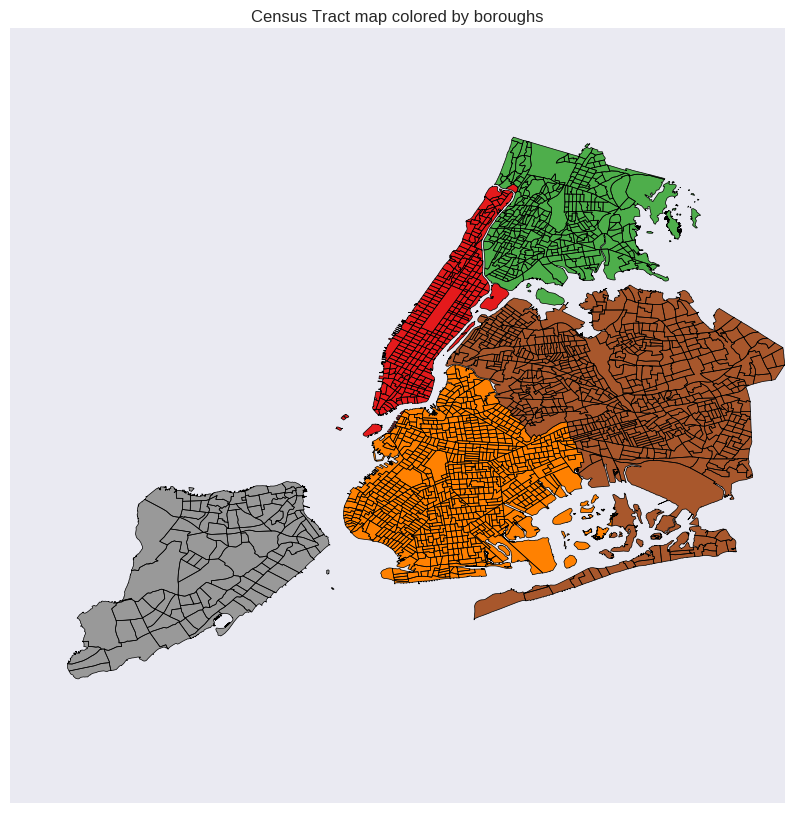

In [5]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

Figure 1: Map of NYC borough boundaries

### Map NYC Population density

#### Load Census Data for 2010
from http://www.socialexplorer.com/

In [6]:
ct_data=DataFrame.from_csv(os.getenv('PUIDATA') + '/Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str) #make index a string to make it implicit (make sure to do this for both files)

#### Add popuation density to CT shapefile

In [7]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset
ct_shape_pop.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,SE_T002_002
BoroCT2010,,,,,,,,,,,,,
5000900,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,POLYGON ((-74.07920577013245 40.64343078374566...,23590.33
5012500,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,POLYGON ((-74.11618948747538 40.62894119691981...,16629.33
5013301,5013301,5,Staten Island,E,013301,133.01,SI22,West New Brighton-New Brighton-St. George,3903,7.217847e+05,3428.312676,POLYGON ((-74.11719947139957 40.63456809812987...,62810.20
5019700,5019700,5,Staten Island,I,019700,197,SI07,Westerleigh,3903,3.231720e+06,9097.697226,POLYGON ((-74.13122302263596 40.61726518212697...,16109.98
5002002,5002002,5,Staten Island,I,002002,20.02,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,8.501224e+06,12591.725901,"POLYGON ((-74.0635056566019 40.60215005483046,...",10606.82


#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


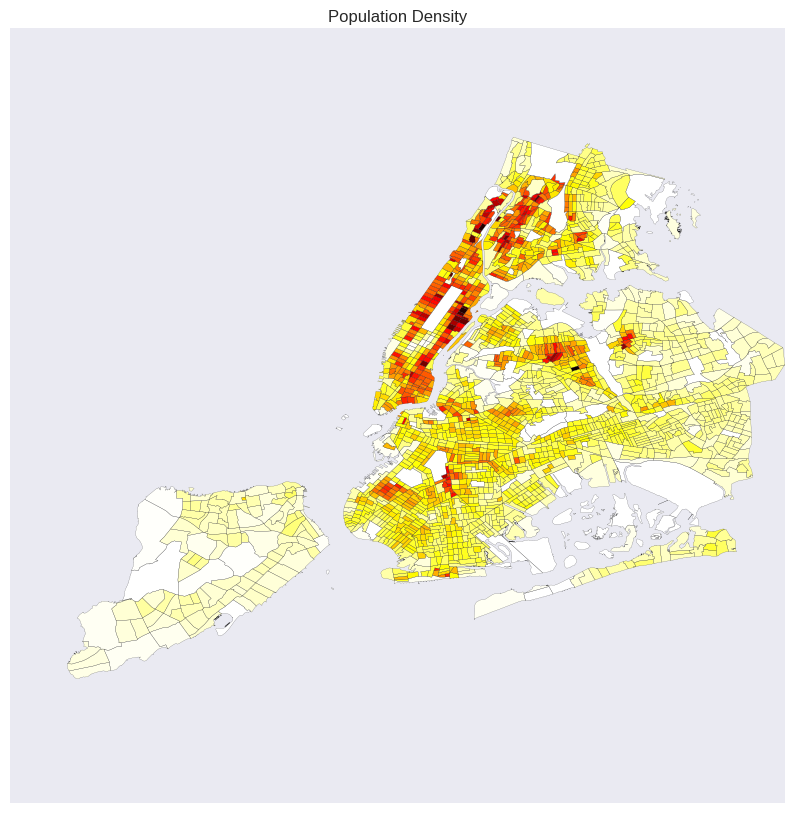

In [8]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax) #column is the population density
plt.title("Population Density")

Figure 2: Map of NYC population density by census tract.

## Explore CitiBike data

### Load CitiBike data

In [95]:
df_bike_monthly=DataFrame.from_csv(os.getenv('PUIDATA') + '/Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


In [96]:
df_bike_monthly2 = df_bike_monthly.copy()

In [98]:
df_bike_monthly2['datetime'] = pd.to_datetime(df_bike_monthly2.index)

In [99]:
#df_bike_monthly2['datetime'] = pd.to_datetime(df_bike_monthly2['starttime'])

In [101]:
df_bike_monthly2['month'] = df_bike_monthly2['datetime'].map(lambda x: x.month)

In [102]:
df_bike_monthly2['season'] = np.where((df_bike_monthly2['month'] == 12) 
                                      | (df_bike_monthly2['month'] == 1) 
                                      | (df_bike_monthly2['month'] == 2), 'Winter',
                                     (np.where((df_bike_monthly2['month'] == 3) 
                                      | (df_bike_monthly2['month'] == 4) 
                                      | (df_bike_monthly2['month'] == 5), 'Spring',
                                     (np.where((df_bike_monthly2['month'] == 6) 
                                      | (df_bike_monthly2['month'] == 7) 
                                      | (df_bike_monthly2['month'] == 8), 'Summer',
                                     (np.where((df_bike_monthly2['month'] == 9) 
                                      | (df_bike_monthly2['month'] == 10) 
                                      | (df_bike_monthly2['month'] == 11), 'Fall',"")))))))

In [103]:
df_bike_Summer = df_bike_monthly2[df_bike_monthly2.season == 'Summer']
df_bike_Summer.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1536,1537,1538,1539,1540,1541,1542,datetime,month,season
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,2013-07-31,7,Summer
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,2013-08-31,8,Summer
2014-06-30,2048,3306,9626,3515,7255,2942,1917,3702,3694,2422,...,0,0,0,0,0,0,0,2014-06-30,6,Summer
2014-07-31,2252,3216,9825,3509,7014,3224,2195,3732,4042,2268,...,0,0,0,0,0,0,0,2014-07-31,7,Summer
2014-08-31,2179,3004,10196,3573,7328,3311,2213,4078,4011,2168,...,0,0,0,0,0,0,0,2014-08-31,8,Summer


In [104]:
df_bike_Winter = df_bike_monthly2[df_bike_monthly2.season == 'Winter']
df_bike_Winter.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1536,1537,1538,1539,1540,1541,1542,datetime,month,season
starttime,,,,,,,,,,,,,,,,,,,,,
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,2013-12-31,12,Winter
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,2014-01-31,1,Winter
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,2014-02-28,2,Winter
2014-12-31,1052,1304,4501,1783,2985,2091,779,2108,1636,878,...,0,0,0,0,0,0,0,2014-12-31,12,Winter
2015-01-31,833,0,3186,1248,1992,1429,442,1499,1366,619,...,0,0,0,0,0,0,0,2015-01-31,1,Winter


### Time Series Analysis

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

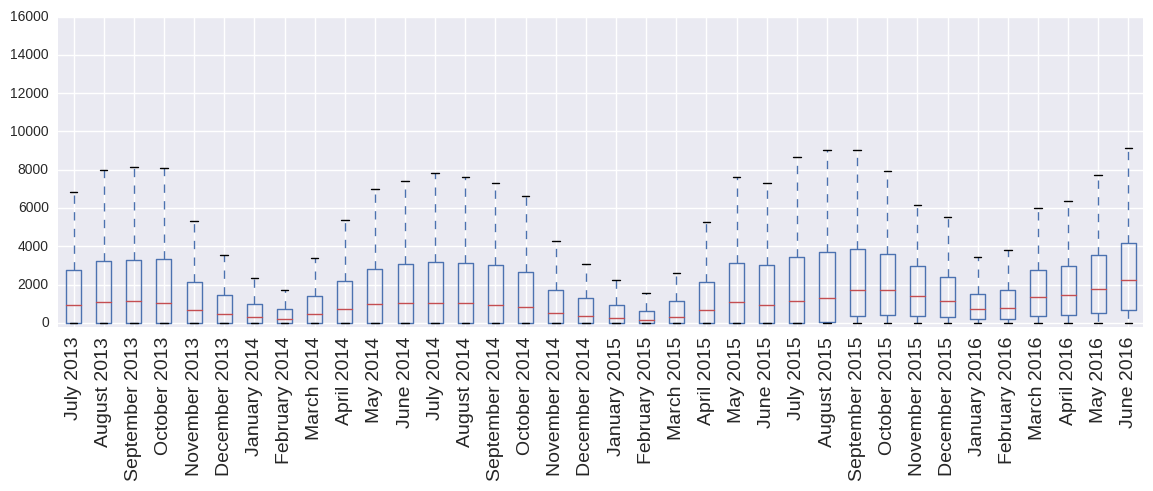

In [107]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

Figure 3: Average number of rides per month from July 2013 to June 2016.  Shows seasonality trend.

#### Seasonal Decomposition

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


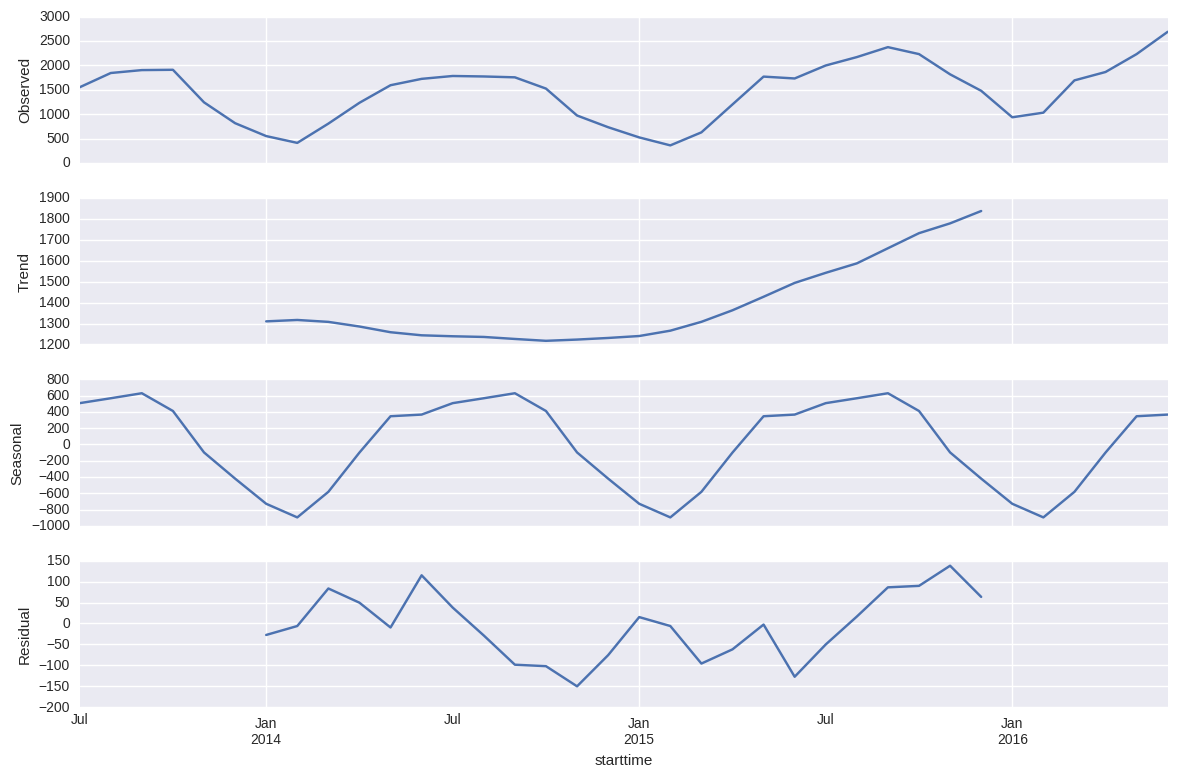

In [108]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

Figure 4: Timeseries charts to demonstrate seasonality of rider trends.  Overall trend shows increase in ridership over time.  Seasonal shows recurring fluctionations which is verified by the residual in terms of seasonality.

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [109]:
station_id=DataFrame.from_csv(os.getenv('PUIDATA') + '/Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [110]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [111]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [112]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [113]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve']=df_bike_monthly.sum()
station_id['SummerAve']=df_bike_Summer.sum()
station_id['WinterAve']=df_bike_Winter.sum()

In [114]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve,SummerAve,WinterAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308,22422,9456
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824,32869,11373
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525,87375,36543
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949,33018,14170
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044,59890,21889


### Add the monthly average rides to the CT shapefile 

In [115]:
# use the 
temp=station_id[['MonthlyAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [116]:
#Seasons
Summertemp=station_id[['SummerAve']]
Summertemp['station_id']=station_id.index
Summertemp.index=station_id['BoroCT2010']
ct_shape_SummerAve=ct_shape.join(Summertemp)
ct_shape_SummerAve.fillna(0,inplace=True)

Wintertemp=station_id[['WinterAve']]
Wintertemp['station_id']=station_id.index
Wintertemp.index=station_id['BoroCT2010']
ct_shape_WinterAve=ct_shape.join(Wintertemp)
ct_shape_WinterAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


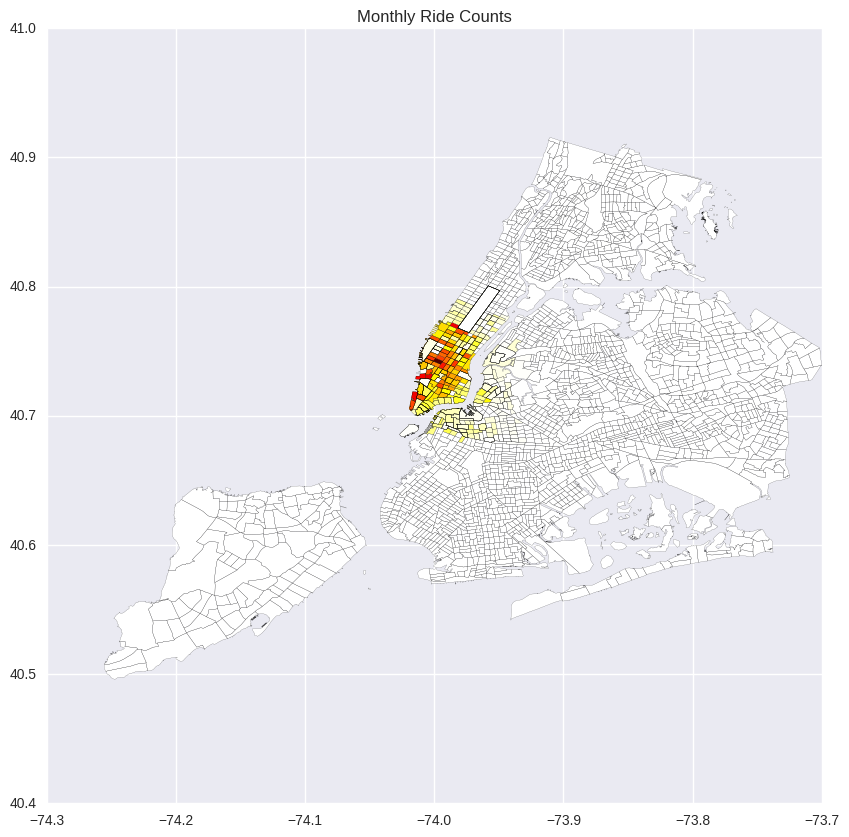

In [118]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

Figure 5: Preliminary map of ride counts by month.  Further discussion below.

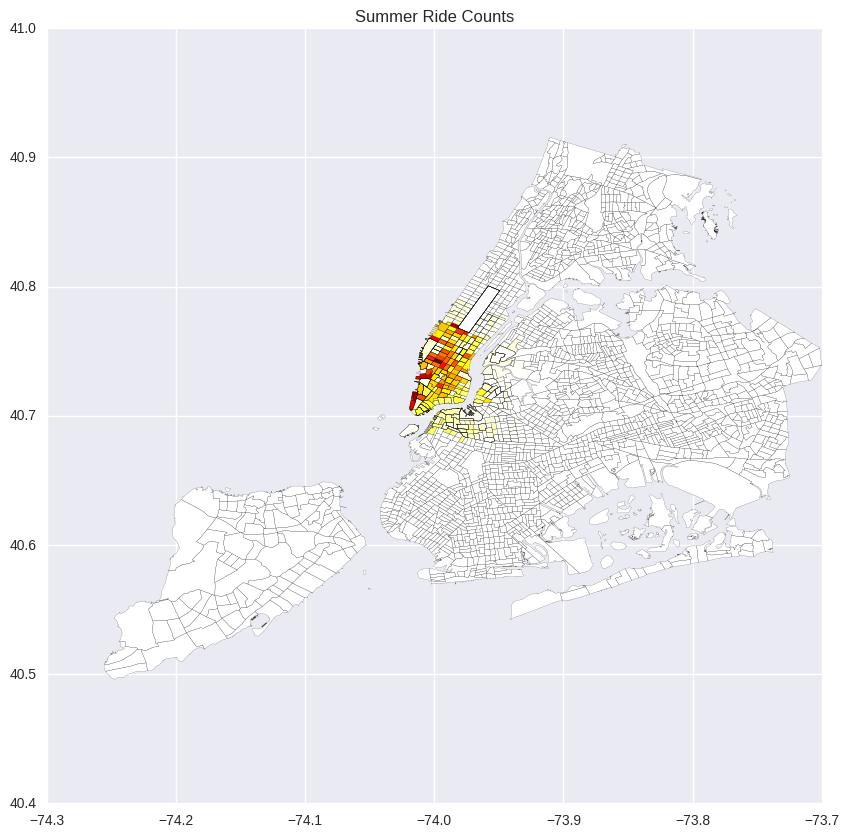

In [119]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_SummerAve.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")

Figure 6: Preliminary map of ride counts for summer month. Further discussion below.

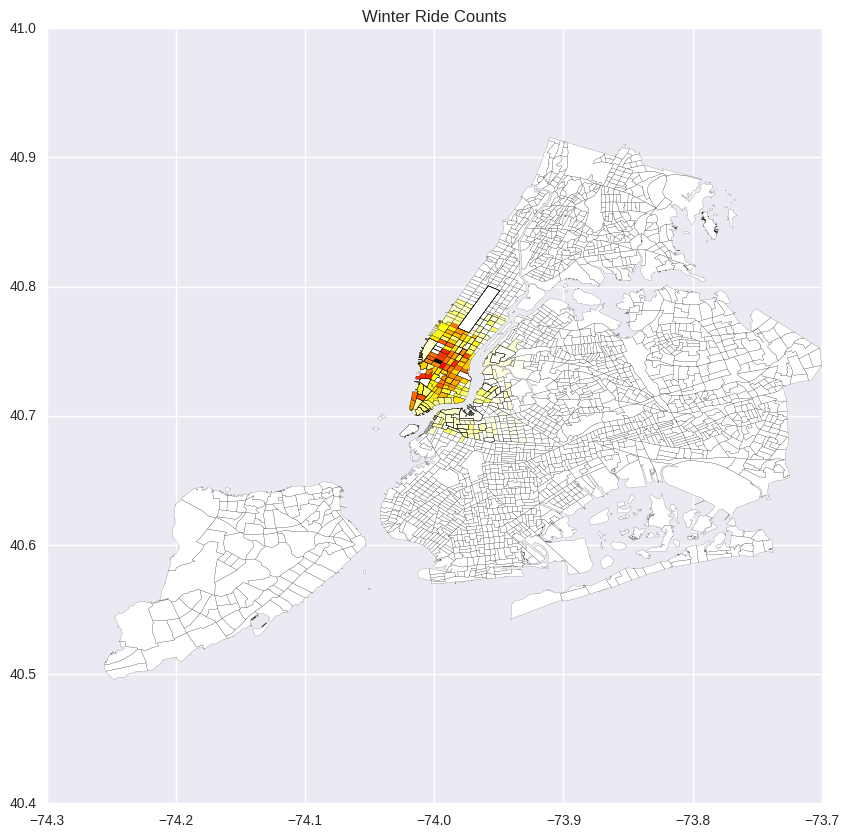

In [120]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_WinterAve.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")

Figure 7: Preliminary map of ride counts for winter month. Further discussion below.

### Removing the CTs that are out of zoom boundries

In [125]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

ct_shape_SummerAve_Zoom=(ct_shape_SummerAve[ct_shape_SummerAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

ct_shape_WinterAve_Zoom=(ct_shape_WinterAve[ct_shape_WinterAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [123]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs Monthly:", len(temp.MonthlyAve)
print "Number of zoomed CTs Summer:", len(Summertemp.SummerAve)
print "Number of zoomed CTs Winter:", len(Wintertemp.WinterAve)

 Total number of CTs: 2166
Number of zoomed CTs Monthly: 543
Number of zoomed CTs Summer: 543
Number of zoomed CTs Winter: 543


### Map the monthly rides 

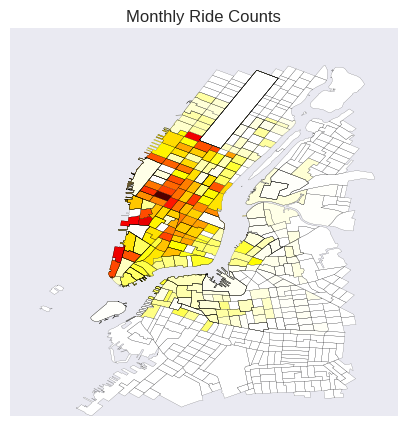

In [129]:
f, ax = plt.subplots(figsize=(5,5))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

Figure 8: Ride counts by month. Darker red areas in downtown Manhattan show high ridership.  Lighter yellow/white census tracts in the surrounding area show little to no ridership.

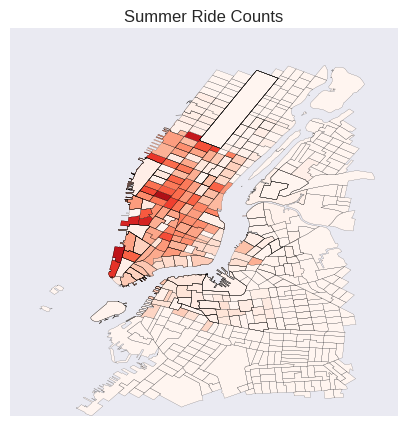

In [135]:
f, ax = plt.subplots(figsize=(5,5))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_SummerAve_Zoom.plot(column='SummerAve',colormap='Reds',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")

Figure 9: Ride counts for summer months. Darker red areas in downtown Manhattan show high ridership.  Lighter red census tracts in the surrounding area show little to no ridership.

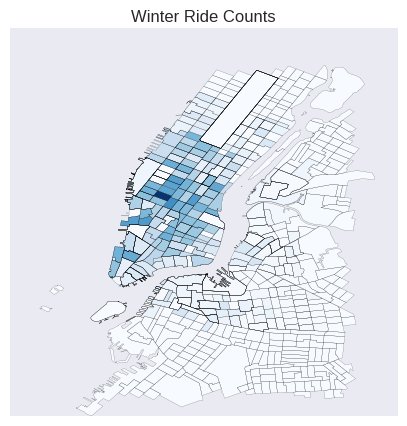

In [134]:
f, ax = plt.subplots(figsize=(5,5))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_WinterAve_Zoom.plot(column='WinterAve',colormap='Blues',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")

Figure 10: Ride counts for winter months. Darker bluee areas in downtown Manhattan show high ridership.  Lighter blue census tracts in the surrounding area show little to no ridership.

### Export Shapefile CTs in the CitiBike Zone

In [148]:
path = os.getenv('PUIDATA') + '/Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)
Summerpath = os.getenv('PUIDATA') + '/Output/ct_shape_SummerAve_Zoom.shp'
ct_shape_SummerAve_Zoom.to_file(Summerpath)
Winterpath = os.getenv('PUIDATA') + '/Output/ct_shape_WinterAve_Zoom.shp'
ct_shape_WinterAve_Zoom.to_file(Winterpath)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [192]:
qW_CT=ps.queen_from_shapefile(path)

Island id:  [0]


In [193]:
qW_CT_Summer=ps.queen_from_shapefile(Summerpath)

Island id:  [0]


In [194]:
qW_CT_Winter=ps.queen_from_shapefile(Winterpath)

Island id:  [0]


#### Neighbors of index10

In [195]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [196]:
qW_CT_Summer[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [197]:
qW_CT_Winter[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [198]:
qW_CT.cardinalities[10]

9

In [199]:
qW_CT_Summer.cardinalities[10]

9

In [200]:
qW_CT_Winter.cardinalities[10]

9

#### Matrix of Weights

In [201]:
Wmatrix, ids = qW_CT.full()
WmatrixSummer, ids = qW_CT_Summer.full()
WmatrixWinter, ids = qW_CT_Winter.full()

In [202]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [203]:
qW_CT.transform = 'r'

In [204]:
qW_CT_Winter.transform = 'r'

In [205]:
qW_CT_Summer.transform = 'r'

### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [206]:
MonthlyRide=ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag=ps.lag_spatial(qW_CT, MonthlyRide)

In [207]:
SummerRide=ct_shape_SummerAve_Zoom.SummerAve
SummerRideLag=ps.lag_spatial(qW_CT_Summer, SummerRide)

In [208]:
WinterRide=ct_shape_WinterAve_Zoom.WinterAve
WinterRideLag=ps.lag_spatial(qW_CT_Winter, WinterRide)

#### Create Quantiles for maping

In [209]:
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10

                    Quantiles                    
 
  Lower                Upper                Count
             x[i] <=      0.000               140
     0.000 < x[i] <=    237.571                21
   237.571 < x[i] <=   4167.561                78
  4167.561 < x[i] <=  10026.857                80
 10026.857 < x[i] <=  17493.404                79
 17493.404 < x[i] <=  26977.053                80
 26977.053 < x[i] <=  58126.278                79
 58126.278 < x[i] <=  81788.042                80
 81788.042 < x[i] <=  96870.015                79
 96870.015 < x[i] <= 151983.357                80

In [210]:
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
SummerRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    49.286                 2
   49.286 < x[i] <=   882.900                78
  882.900 < x[i] <=  2346.833                80
 2346.833 < x[i] <=  5645.067                84
 5645.067 < x[i] <=  8593.933                75
 8593.933 < x[i] <= 19189.030                79
19189.030 < x[i] <= 27831.071                80
27831.071 < x[i] <= 32327.735                79
32327.735 < x[i] <= 49147.643                80

In [211]:
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
WinterRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    36.286                 2
   36.286 < x[i] <=   603.729                78
  603.729 < x[i] <=  1458.923                80
 1458.923 < x[i] <=  2284.227                79
 2284.227 < x[i] <=  3278.714                80
 3278.714 < x[i] <=  7763.237                79
 7763.237 < x[i] <= 10456.870                80
10456.870 < x[i] <= 12783.385                79
12783.385 < x[i] <= 20551.286                80

#### Map the monthly rides lag

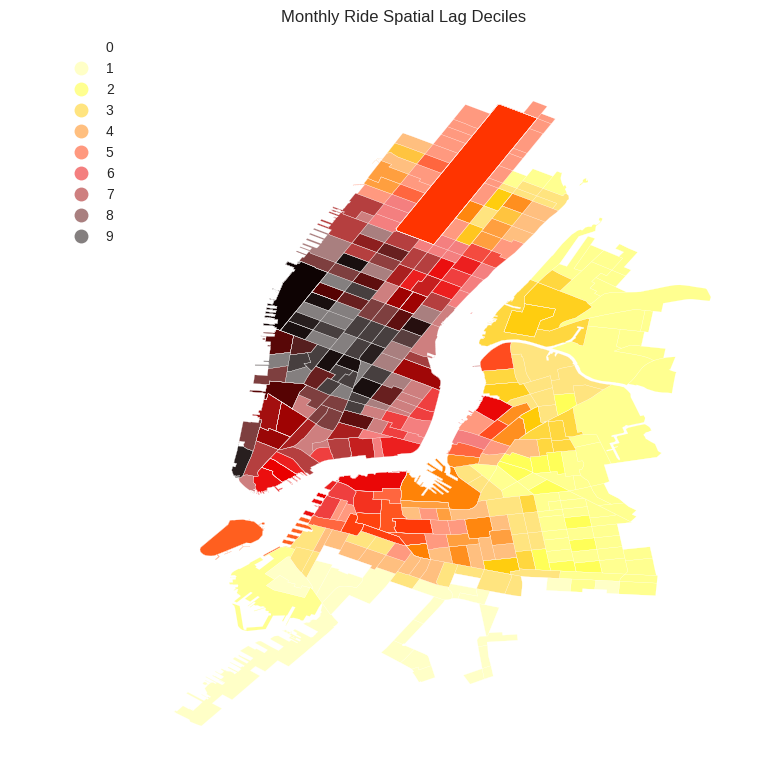

In [212]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles")


Figure 11: Spatial lag mapping by 0-9 deciles.  Spatial lag tests whetehr neighboring observations affect one another. Higher deciles indicate higher influence from neighbors.

The idea is that -- apart from the influence of the independent variables like county population density or unemployment rates -- areas with high ridership might be adjacent to other high rider areas, and therefore there is a spatial trend in the outcome variable. The example shows that an interesting variable like population density can become statistically insignificant when spatial dependence is taken into account, and that coefficients of other variables can change in magnitude.
http://projects.iq.harvard.edu/sss_blog/spatial_lag_1

A spatial lag (SL) model assumes that dependencies exist directly among the levels of the dependent variable.
That is, the income at one location is affected by the income at the nearby locations.
A "lag" term, in this case is a specification of ridership at nearby locations, is included in the regression, and its coefficient and p-value are interpreted as for the independent variables.
The SL model should account for spatial dependencies and the SL residuals would not be autocorrelated,
Hence the SL residuals should not be distinguishable from random noise (i.e., have no consistent patterns or dependencies in them)
http://www.bisolutions.us/A-Brief-Introduction-to-Spatial-Regression.php

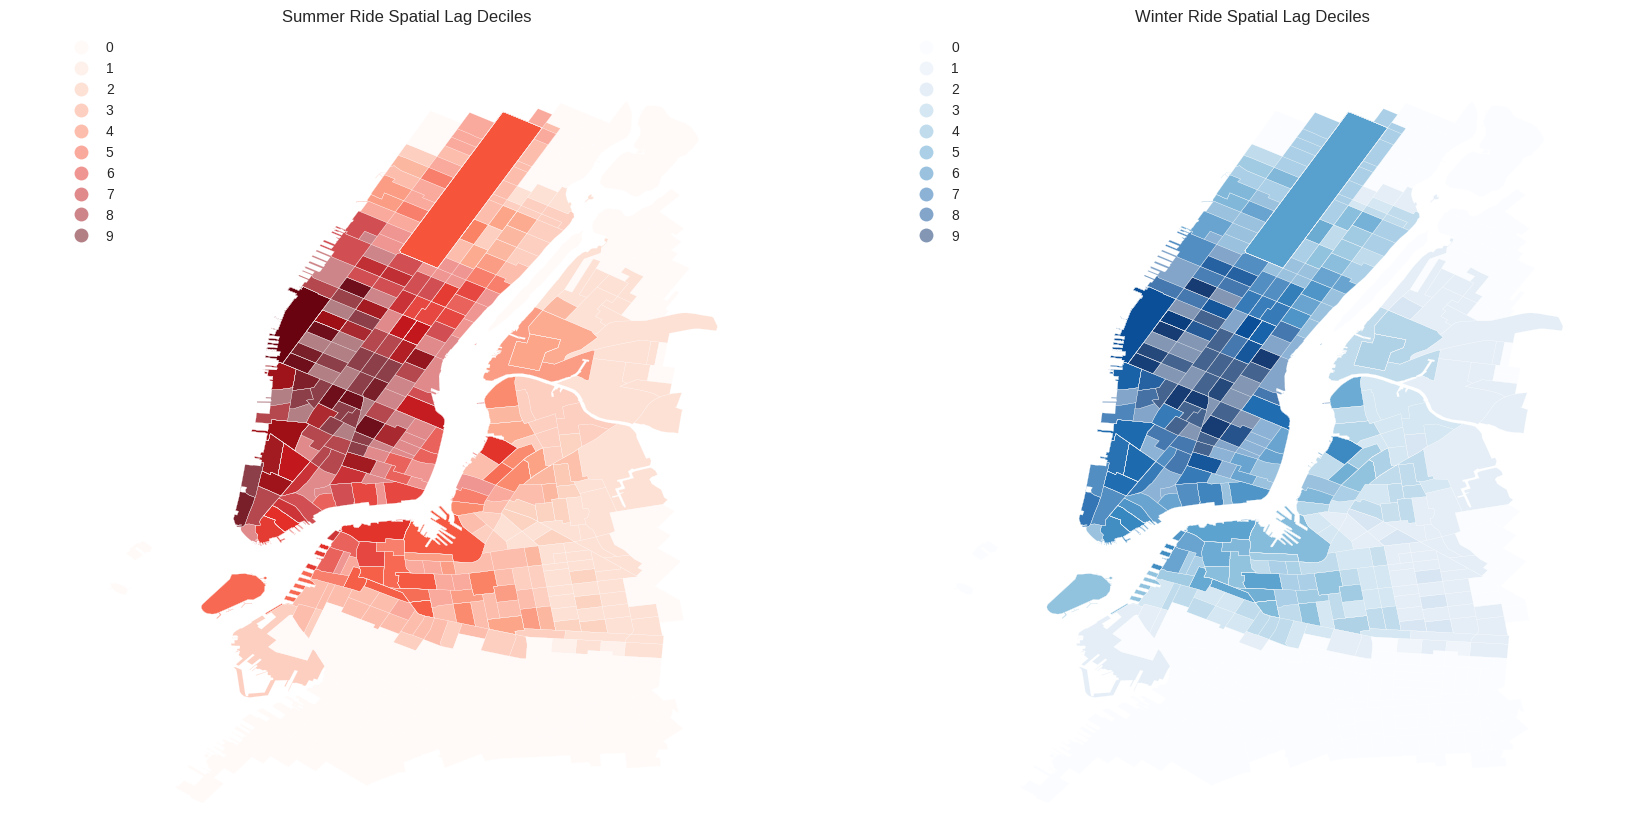

In [213]:
f, ax = plt.subplots(figsize=(20, 10))
ax1 = plt.subplot(121)
ct_shape_SummerAve_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='Reds', linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
plt.title("Summer Ride Spatial Lag Deciles")

ax2 = plt.subplot(122)
ct_shape_WinterAve_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='Blues', linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax2.set_axis_off()
plt.title("Winter Ride Spatial Lag Deciles")

Figure 12: Spatial lag mapping by 0-9 deciles.  Spatial lag tests whether neighboring observations affect one another. Higher deciles indicate higher influence from neighbors.

## Global  Spatial Autocorrelation

In [214]:
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

(0.65563669282948467, 12557.637062387894)

In [215]:
b2,a2 = np.polyfit(SummerRide, SummerRideLag, 1)
print(b2,a2)
b3,a3 = np.polyfit(WinterRide, WinterRideLag, 1)
print(b3,a3)

(0.64335490815356511, 4220.5552980795601)
(0.66023249858156818, 1600.8324238675889)


### Moran Scatterplot

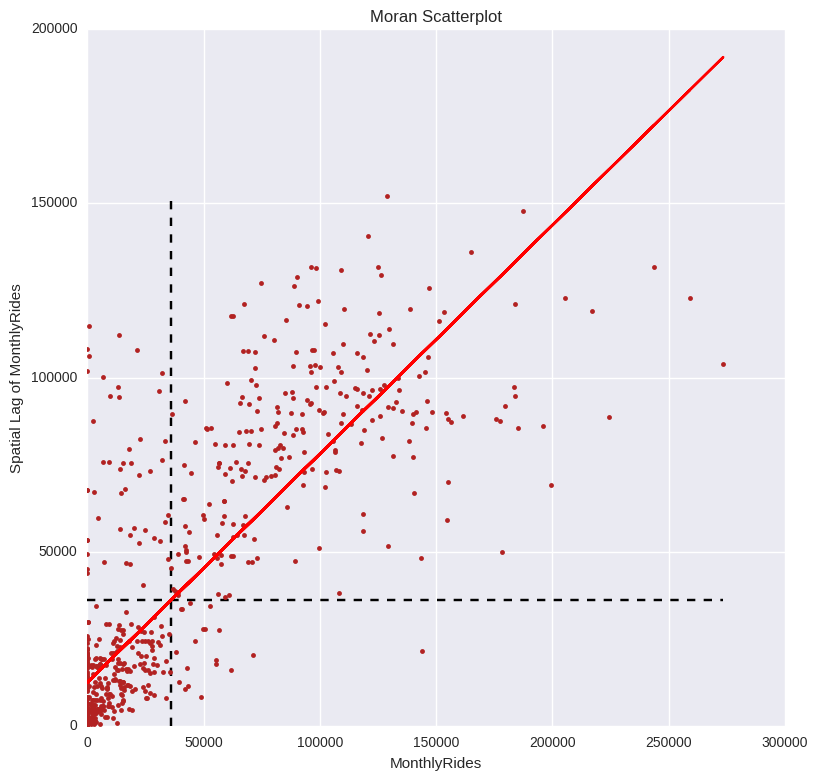

In [216]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide, MonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

Figure 13: Moran scatterplot maps census tracts in accordance to its spatial lag of monthly rides relative to its neighbors.  Upper right quadrant shows high monthly rides with similar high ridership neighbors.  In contrast, lower left shows low monthly rides with similar low ridership neighbors.

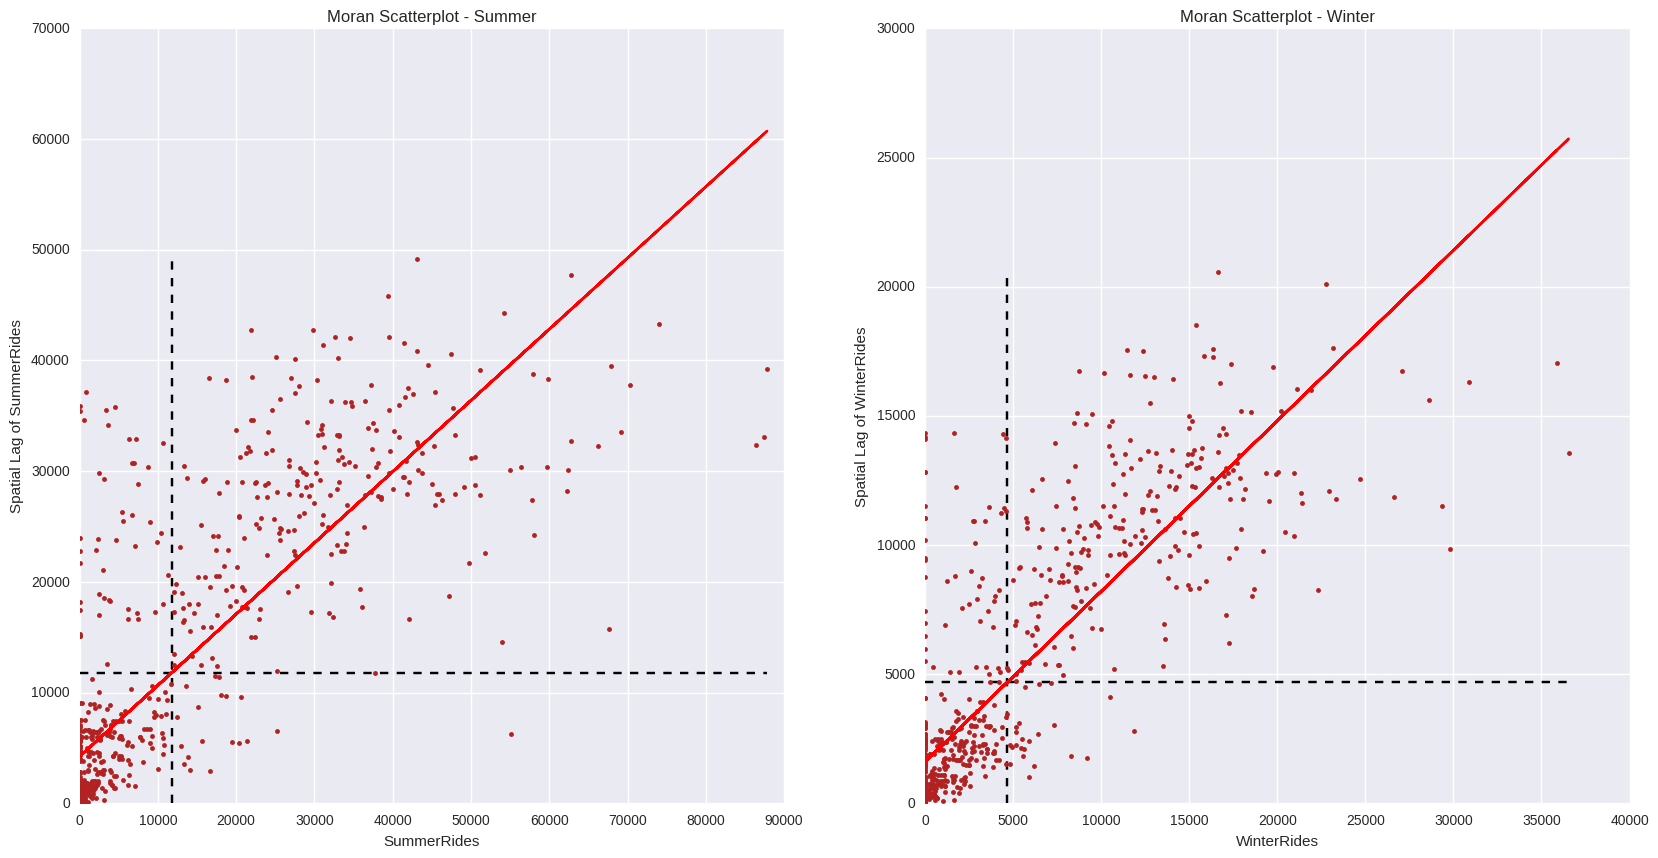

In [217]:
f, ax = plt.subplots(1, figsize=(20, 10))

ax1 = plt.subplot(121)
ax1.plot(SummerRide, SummerRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
ax1.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax1.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax1.plot(SummerRide, a2 + b2*SummerRide, 'r')
plt.title('Moran Scatterplot - Summer')
plt.ylabel('Spatial Lag of SummerRides')
plt.xlabel('SummerRides')

ax2 = plt.subplot(122)
ax2.plot(WinterRide, WinterRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
ax2.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax2.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax2.plot(WinterRide, a3 + b3*WinterRide, 'r')
plt.title('Moran Scatterplot - Winter')
plt.ylabel('Spatial Lag of WinterRides')
plt.xlabel('WinterRides')


Figure 14: Moran scatterplot for summer and winter months.

### Moran's I

In [220]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)

In [221]:
I_MonthlyRide.I, I_MonthlyRide.p_sim

(0.65579332908409083, 0.001)

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [222]:
I_MonthlyRide.sim[0:10]

array([-0.0005107 , -0.02370713,  0.04521458, -0.02215703,  0.00183952,
       -0.00660637,  0.00358724,  0.00766609,  0.00508895,  0.02330277])

In [223]:
I_SummerRide = ps.Moran(SummerRide, qW_CT_Summer)
print(I_SummerRide.I, I_SummerRide.p_sim)
print(I_SummerRide.sim[0:10])

(0.64353398667011008, 0.001)
[-0.00956632  0.02140357  0.01498148  0.00051182  0.02536552 -0.00889861
 -0.03431042 -0.02254566 -0.00483993  0.0083983 ]


In [224]:
I_WinterRide = ps.Moran(WinterRide, qW_CT_Winter)
print(I_WinterRide.I, I_WinterRide.p_sim)
print(I_WinterRide.sim[0:10])

(0.66039156431885593, 0.001)
[-0.00665744 -0.01426325 -0.01633061 -0.02053002 -0.01851487 -0.01489593
 -0.00877479 -0.00542622 -0.00929638  0.00626083]


### KDEplot of all of the simulated points
the vertical line shows the observed value

In [225]:
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

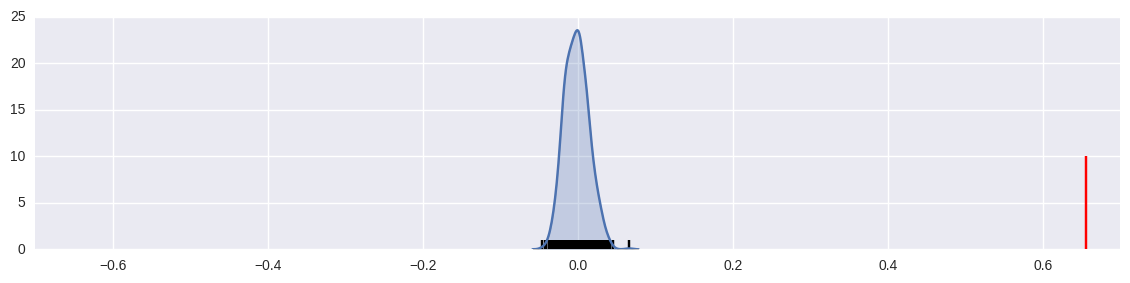

In [226]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

Figure 15: the vertical line shows the observed value way off the expected.

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

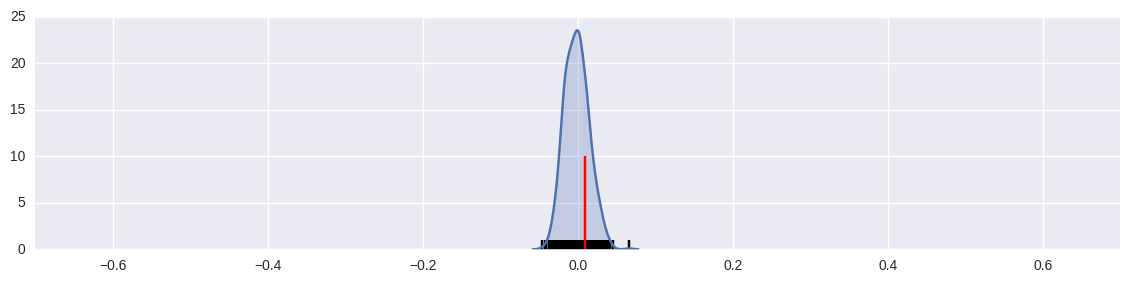

In [227]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

Figure 16: the vertical line is showing if our I statistic were close to our expected value

## Local  Spatial Autocorrelation

In [238]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)

ValueError: Lengths must match to compare

In [232]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

NameError: name 'LMo_MonthlyRide' is not defined

In [236]:
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT_Summer,permutations=999)
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

ValueError: Lengths must match to compare

In [234]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT_Winter,permutations=999)
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

ValueError: Lengths must match to compare

### LISA (Local Indicators of Spatial Autocorrelation)

In [235]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

NameError: name 'LMo_MonthlyRide' is not defined

In [ ]:
sigs_Summer = SummerRide[LMo_SummerRide.p_sim <= .001]
W_sigs_Summer = SummerRideLag[LMo_SummerRide.p_sim <= .001]
insigs_Summer = SummerRide[LMo_SummerRide.p_sim > .001]
W_insigs_Summer = SummerRideLag[LMo_SummerRide.p_sim > .001]

In [ ]:
sigs_Winter = WinterRide[LMo_WinterRide.p_sim <= .001]
W_sigs_Winter = WinterRideLag[LMo_WinterRide.p_sim <= .001]
insigs_Winter = WinterRide[LMo_WinterRide.p_sim > .001]
W_insigs_Winter = WinterRideLag[LMo_WinterRide.p_sim > .001]

### Plot Signficant LISA

NameError: name 'sigs' is not defined

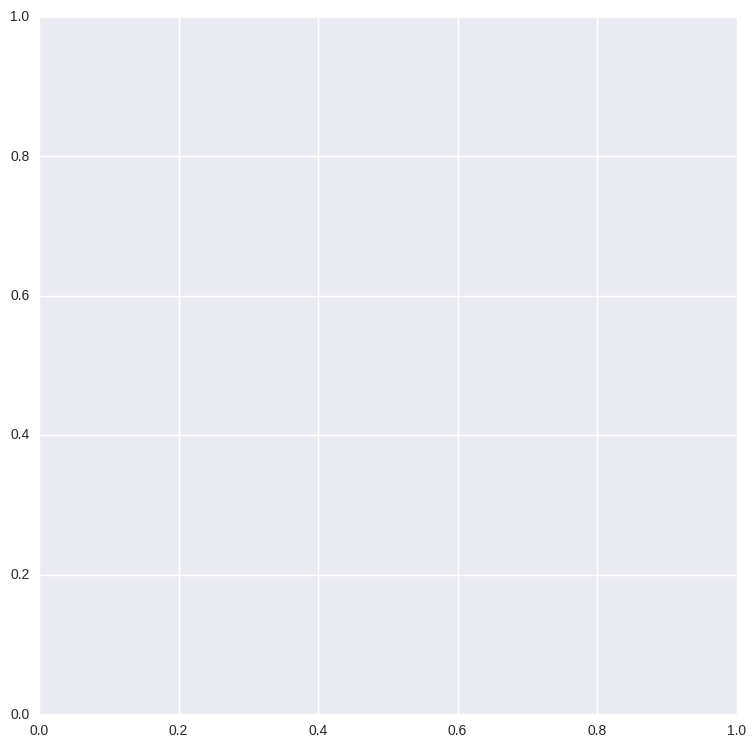

In [237]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

Figure 17: Significant LISA

In [ ]:
f, ax = plt.subplots(figsize=(9, 9))

ax1 = plt.subplot(121)
ax1.plot(sigs, W_sigs_Summer, '.', color='firebrick')
ax1.plot(insigs_Summer, W_insigs_Summer, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_SummerRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
ax1.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax1.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax1.plot(SummerRide, a + b*SummerRide, 'r')
plt.title('Moran Scatterplot for Summer Months')
plt.ylabel('Spatial Lag of SummerRides')
plt.xlabel('Summer Rides')

ax2 = plt.subplot(122)
ax2.plot(sigs, W_sigs_Winter, '.', color='firebrick')
ax2.plot(insigs_Winter, W_insigs_Winter, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_WinterRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
ax2.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax2.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax2.plot(WinterRide, a + b*WinterRide, 'r')
plt.title('Moran Scatterplot for Winter Months')
plt.ylabel('Spatial Lag of WinterRides')
plt.xlabel('Winter Rides')


Figure 18: Significant LISA for summer and winter months

### Hot and Cold spots 

In [46]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q==1 * sig
coldspots = LMo_MonthlyRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 192
Number of Coldspots: 237


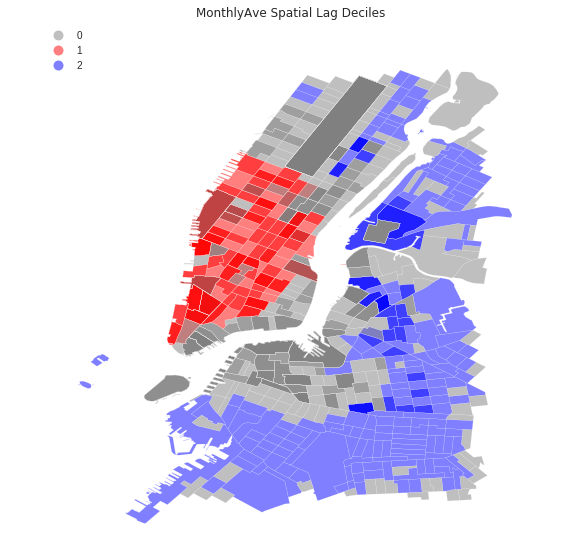

In [47]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")

Figure 19: Final mapping of cold and hot spots for all months.

In [ ]:
sig_Summer = LMo_SummerRide.p_sim < 0.01
hotspots_Summer = LMo_SummerRide.q==1 * sig
coldspots_Summer = LMo_SummerRide.q==3 * sig
print "Number of Hotspots:", hotspots_Summer.sum()
print "Number of Coldspots:", coldspots_Summer.sum()

hcmap_Summer = colors.ListedColormap(['grey','red','blue'])
hotcold_Summer = hotspots_Summer*1 + coldspots_Summer*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_SummerAve_Zoom.assign(cl=hotcold_Summer).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("SummerAve Spatial Lag Deciles")

Figure 20: Final mapping of cold and hot spots for summer months.

In [ ]:
sig_Winter = LMo_WinterRide.p_sim < 0.01
hotspots_Winter = LMo_WinterRide.q==1 * sig
coldspots_Winter = LMo_WinterRide.q==3 * sig
print "Number of Hotspots:", hotspots_Winter.sum()
print "Number of Coldspots:", coldspots_Winter.sum()

hcmap_Winter = colors.ListedColormap(['grey','red','blue'])
hotcold_Winter = hotspots_Winter*1 + coldspots_Winter*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_WinterAve_Zoom.assign(cl=hotcold_Winter).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("WinterAve Spatial Lag Deciles")

Figure 21: Final mapping of cold and hot spots for winter months.